# Обработка данных самописцев уровней воды

Принцип работы датчиков самописцев уровней воды основан на суммарном измерении давления толщи воды и атоммосферного воздуха. Поэтому для определения уровня воды из сумарного давления необходимо вычитать атмосферное давление. После компенсации атмосферного давления относительный уровень воды, измеряемый датчиком, необходимо перевести в абсолютные отметки балтийской системы высот. Он осуществляется с помощью измереной абсолютной отметки уровня воды в результате топографо-геодезичесих работ. Имеющаяся информация по абсолютным отметкам уровня воды (Набс, м БС) и точное времея на момент засечки уреза воды при измерении уровня воды от датчика позволяет рассчитать высоту датчика над уровнем моря (м БС), используя измеренное значение глубины расположения самописца следующим образом:

$$H_{абс. уреза} = P_{датчика} - P_{атм} + H_{абс.датчика}$$

Этапы:
1. Импорт библиотек
2. Компенсация атмосферного давления
3. Подготовка данных
4. Приведение относительного уровня воды к абсолютным отметкам балтийской системы высот

## Импорт библиотек, подгрузка данных, конвертация

In [324]:
# импорт библиотек
import pandas as pd
import xarray as xr
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cdsapi
import warnings
warnings.filterwarnings("ignore")

Библиотеки успешно импортированны.

## Компенсация атмосферного давления

### Загрузка атмосферного давления ре-анализа ERA5

Загрузка будет осуществляться через API ECMWF. Для этого нужно сформировать файл с токеном. Инструкция [здесь](https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows). Запрос можно сформировать выбрав необходимый [набор данных](https://cds.climate.copernicus.eu/#!/search?text=ERA5&type=dataset) и перейти во вкаладку "Download data". Ниже представлен запрос на атмосферное давление с июня по июль для территории. 

In [325]:
# подключение к API
c = cdsapi.Client()

# запрос
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 'surface_pressure',
        'year': '2022',
        'month': [
            '06', '07',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            60.50, 165.75, 60.25,
            166.25,
        ],
    },
    'pressure.nc')

2022-11-17 13:21:31,043 INFO Welcome to the CDS
2022-11-17 13:21:31,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-11-17 13:21:31,293 INFO Request is queued
2022-11-17 13:21:32,368 INFO Request is running
2022-11-17 13:23:25,364 INFO Request is completed
2022-11-17 13:23:25,366 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.internal-1668680569.2420673-21829-1-1287b0ea-a157-461b-9749-47637ca4fef2.nc to pressure.nc (24K)
2022-11-17 13:23:25,835 INFO Download rate 51.1K/s                                                                     


Result(content_length=24560,content_type=application/x-netcdf,location=https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.internal-1668680569.2420673-21829-1-1287b0ea-a157-461b-9749-47637ca4fef2.nc)

Загрузили файл pressure.nc c информацией об атмосферном давлении в паскалях в ячейках с июня по июль.

### Импорт .nc и преобразование в .csv

In [326]:
# прописываем пути к файлам
netcdf_dir = path
csv_dir = netcdf_dir
netcdf_file_name = 'pressure.nc'
netcdf_file_in = netcdf_dir + netcdf_file_name
csv_file_out = csv_dir + netcdf_file_name[:-3] + '.csv'

In [327]:
# импорт netcdf и преобразование с dataframe
ds = xr.open_dataset(netcdf_file_in)
df = ds.to_dataframe()

# сохранение csv
df.to_csv(csv_file_out)

In [328]:
# сделаем индексом столбец по времени
df = df.reset_index().set_index('time')

Посмотрим что получилось.

In [329]:
df.head()

,longitude,latitude,sp
time,,,
2022-06-01 00:00:00,165.75,60.5,100072.718750
2022-06-01 01:00:00,165.75,60.5,100060.742188
2022-06-01 02:00:00,165.75,60.5,100044.890625
2022-06-01 03:00:00,165.75,60.5,100008.960938
2022-06-01 04:00:00,165.75,60.5,100012.382812


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2022-06-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  8784 non-null   float64
 1   latitude   8784 non-null   float64
 2   sp         8784 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 240.2 KB


Переводим паскали в метры водного столба.

In [331]:
df['p_mwst'] = df['sp'] / 9.80665 / 1000

- Преобразовали .nc в .csv для дальнейшей работы;
- Преобразовали паскали в метры водного столба - именно в них измерятся давление в самописах уровней воды.

## Интерполяция и изменение временного масштаба данных 

В связи с тем, что запись самопицев уровней воды велась с дискретностью 15 мин, данные о давлении нуждаются в ресемпле к этой дискретности. Нас интересует только одна ячейка с координатами центра 60.25, 166.00. Отфильтруем давление по этим координатам.

In [332]:
df_6025_166 = df[(df['longitude'].isin([166.]))
            & (df['latitude'].isin([60.25]))]

In [333]:
df_6025_166.head()

,longitude,latitude,sp,p_mwst
time,,,,
2022-06-01 00:00:00,166.0,60.25,101376.703125,10.337547
2022-06-01 01:00:00,166.0,60.25,101363.757812,10.336226
2022-06-01 02:00:00,166.0,60.25,101345.898438,10.334405
2022-06-01 03:00:00,166.0,60.25,101312.945312,10.331045
2022-06-01 04:00:00,166.0,60.25,101317.406250,10.331500


In [334]:
# делеем ресемпл на 15 минут с линейной интерполяцией
df_6025_166 = df_6025_166.resample('15min').interpolate(method ='linear').reset_index()

Посмотрим на линейный график динамики атмосферного давления.

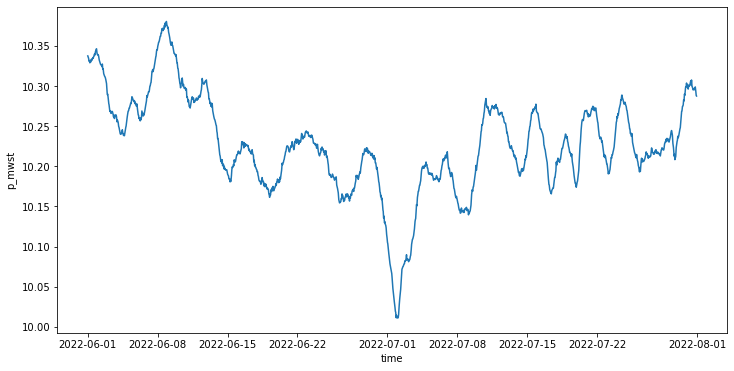

In [335]:
fig = plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_6025_166, x=df_6025_166['time'], y=df_6025_166['p_mwst'])

Ресемпл осуществлён успешно.

## Приведение относительного уровня воды к абсолютным отметкам балтийской системы высот

В этом разделе проведём компенсацию давлений. Ниже загрузим файл с общим давление самописцев в м водного столба. Подгрузим данные самописцев.

In [336]:
logs_mwst = pd.read_csv(path, sep=';')

In [337]:
logs_mwst.head()

,date_time,log_1,log_2,log_3,log_4
0,26.06.22 10:15,10.955055,10.867300,10.802263,NaN
1,26.06.22 10:30,10.946031,10.852983,10.785143,NaN
2,26.06.22 10:45,10.950701,10.838983,10.762424,NaN
3,26.06.22 11:00,10.970616,10.827154,10.745619,NaN
4,26.06.22 11:15,10.999861,10.824972,10.730691,NaN


Вычислим уровень *воды* для каждого самописца вычитанием атмосферного давления. Для этого объеденим таблицы, но сначала преобразуем даты.

In [338]:
logs_mwst['date_time'] = pd.to_datetime(logs_mwst['date_time'], format='%d.%m.%y %H:%M')
logs_merge = pd.merge(logs_mwst, df_6025_166[['time', 'p_mwst']], how='left', left_on='date_time', right_on='time')
logs_merge.head()

,date_time,log_1,log_2,log_3,log_4,time,p_mwst
0,2022-06-26 10:15:00,10.955055,10.867300,10.802263,NaN,2022-06-26 10:15:00,10.160950
1,2022-06-26 10:30:00,10.946031,10.852983,10.785143,NaN,2022-06-26 10:30:00,10.162489
2,2022-06-26 10:45:00,10.950701,10.838983,10.762424,NaN,2022-06-26 10:45:00,10.164029
3,2022-06-26 11:00:00,10.970616,10.827154,10.745619,NaN,2022-06-26 11:00:00,10.165569
4,2022-06-26 11:15:00,10.999861,10.824972,10.730691,NaN,2022-06-26 11:15:00,10.165095


Вычислим толщу воды в метрах. Вычитаем из общего давления атмосферное давление.

In [339]:
logs_merge['log_1_comp_m'] = logs_merge['log_1'] - logs_merge['p_mwst']
logs_merge['log_2_comp_m'] = logs_merge['log_2'] - logs_merge['p_mwst']
logs_merge['log_3_comp_m'] = logs_merge['log_3'] - logs_merge['p_mwst']
logs_merge['log_4_comp_m'] = logs_merge['log_4'] - logs_merge['p_mwst']

In [340]:
logs_merge.head()

,date_time,log_1,log_2,log_3,log_4,time,p_mwst,log_1_comp_m,log_2_comp_m,log_3_comp_m,log_4_comp_m
0,2022-06-26 10:15:00,10.955055,10.867300,10.802263,NaN,2022-06-26 10:15:00,10.160950,0.794105,0.706350,0.641314,NaN
1,2022-06-26 10:30:00,10.946031,10.852983,10.785143,NaN,2022-06-26 10:30:00,10.162489,0.783542,0.690494,0.622654,NaN
2,2022-06-26 10:45:00,10.950701,10.838983,10.762424,NaN,2022-06-26 10:45:00,10.164029,0.786672,0.674954,0.598395,NaN
3,2022-06-26 11:00:00,10.970616,10.827154,10.745619,NaN,2022-06-26 11:00:00,10.165569,0.805046,0.661585,0.580050,NaN
4,2022-06-26 11:15:00,10.999861,10.824972,10.730691,NaN,2022-06-26 11:15:00,10.165095,0.834765,0.659877,0.565595,NaN


Таким образом мы получили высоту уровня воды над датчиком самописца.

Теперь уровень воды нужно привязать к абсолютным отметкам с помощью одномоментно измеренного занчения уровня воды рядом с каждым самописцем.

Ниже создаём таблицу с данными об измеренных урезах воды в м БС.

In [341]:
logs_urez = pd.DataFrame({'log': ['log_1', 'log_2', 'log_3', 'log_4'],
                          'time':['2022-06-27 14:45', '2022-06-27 13:45', '2022-06-27 11:15', '2022-06-30 19:30'],
                          'H_m_bs':[-0.57, -0.86, -1.22, 0.88]})

In [342]:
logs_urez

,log,time,H_m_bs
0,log_1,2022-06-27 14:45,-0.57
1,log_2,2022-06-27 13:45,-0.86
2,log_3,2022-06-27 11:15,-1.22
3,log_4,2022-06-30 19:30,0.88


Поправим формат дат.

In [343]:
logs_urez['time'] = pd.to_datetime(logs_urez['time'], format='%Y-%m-%d %H:%M')

Создадим функци. Первая функция log_H будет искать отметку высоты датчика в м БС. Далее высоту датчика прибавим к записанным относительным уровням воды.

In [344]:
# функция расчитывающа яразницу
def log_H(log_row, log_column):
    for index, row in logs_merge.iterrows():
        if row['time'] == logs_urez.loc[log_row, 'time']:
             H = logs_urez.loc[log_row, 'H_m_bs'] - row[log_column] 
    return H

Применим функцию и создадим столбцы с урезом в балтийской системы высот для каждой точки, где был установлен самописец.

In [345]:
H = log_H(0, 'log_1_comp_m')
logs_merge['log_1_comp_m_bs'] = logs_merge['log_1_comp_m'] + H

H = log_H(1, 'log_2_comp_m')
logs_merge['log_2_comp_m_bs'] = logs_merge['log_2_comp_m'] + H

H = log_H(2, 'log_3_comp_m')
logs_merge['log_3_comp_m_bs'] = logs_merge['log_3_comp_m'] + H

H = log_H(3, 'log_4_comp_m')
logs_merge['log_4_comp_m_bs'] = logs_merge['log_4_comp_m'] + H

In [346]:
logs_merge.head()

,date_time,log_1,log_2,log_3,log_4,time,p_mwst,log_1_comp_m,log_2_comp_m,log_3_comp_m,log_4_comp_m,log_1_comp_m_bs,log_2_comp_m_bs,log_3_comp_m_bs,log_4_comp_m_bs
0,2022-06-26 10:15:00,10.955055,10.867300,10.802263,NaN,2022-06-26 10:15:00,10.160950,0.794105,0.706350,0.641314,NaN,-1.128614,-1.034177,-1.136134,NaN
1,2022-06-26 10:30:00,10.946031,10.852983,10.785143,NaN,2022-06-26 10:30:00,10.162489,0.783542,0.690494,0.622654,NaN,-1.139178,-1.050033,-1.154794,NaN
2,2022-06-26 10:45:00,10.950701,10.838983,10.762424,NaN,2022-06-26 10:45:00,10.164029,0.786672,0.674954,0.598395,NaN,-1.136048,-1.065574,-1.179053,NaN
3,2022-06-26 11:00:00,10.970616,10.827154,10.745619,NaN,2022-06-26 11:00:00,10.165569,0.805046,0.661585,0.580050,NaN,-1.117673,-1.078942,-1.197398,NaN
4,2022-06-26 11:15:00,10.999861,10.824972,10.730691,NaN,2022-06-26 11:15:00,10.165095,0.834765,0.659877,0.565595,NaN,-1.087954,-1.080651,-1.211852,NaN


Осуществим графическое отоброжение уровней воды.

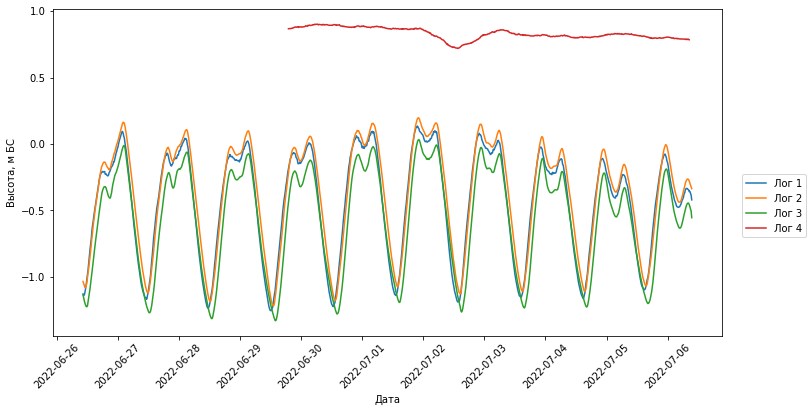

In [347]:
fig = plt.figure(figsize=(12, 6))
sns.lineplot(data=logs_merge, x='time', y='log_1_comp_m_bs')
sns.lineplot(data=logs_merge, x='time', y='log_2_comp_m_bs')
sns.lineplot(data=logs_merge, x='time', y='log_3_comp_m_bs')
sns.lineplot(data=logs_merge, x='time', y='log_4_comp_m_bs')
fig.legend(labels=['Лог 1','Лог 2','Лог 3', 'Лог 4'], loc='center right')
plt.xlabel('Дата')
plt.ylabel('Высота, м БС')
plt.xticks(rotation=45);

Уровни выглядят адекватно.
Сохраним обработанные уровни в csv.

In [348]:
csv_file_out = path
logs_merge[['time', 'log_1_comp_m_bs', 'log_2_comp_m_bs', 'log_3_comp_m_bs', 'log_4_comp_m_bs']].to_csv(csv_file_out)

Данные самописцев обработаны.

## Использованные материалы

- [Тетрадка конвертации NetCDF в csv](https://gist.github.com/copernicusmarinegist/b57417225d0d4ea47c5d6200f9d8cac3);
- [Cтатья об API ECMWF](https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0) о работе с API ECMWF.